# IBM Developer Skills Network

# Convolutional Neural Network

<a id="ref1"></a>

<h2>What is Deep Learning?</h2>

<b>Brief Theory:</b> Deep learning (also known as deep structured learning, hierarchical learning or deep machine learning) is a branch of machine learning based on a set of algorithms that attempt to model high-level abstractions in data by using multiple processing layers, with complex structures or otherwise, composed of multiple non-linear transformations.

<img src="https://ibm.box.com/shared/static/gcbbrh440604cj2nksu3f44be87b8ank.png" alt="HTML5 Icon" style="width: 600px; height: 450px;">
<div style="text-align: center">It's time for deep learning. Our brain doesn't work with only one or three layers. Why it would be different with machines?. </div>


<b>In Practice, defining the term "Deep":</b> in this context, deep means that we are studying a Neural Network which has several hidden layers (more than one), no matter what type (convolutional, pooling, normalization, fully-connected etc). The most interesting part is that some papers noticed that Deep Neural Networks with the right architectures/hyper-parameters achieve better results than shallow Neural Networks with the same computational power (e.g. number of neurons or connections).

<b>In Practice, defining "Learning":</b> In the context of supervised learning, digits recognition in our case, the learning part consists of a target/feature which is to be predicted using a given set of observations with the already known final prediction (label). In our case, the target will be the digit (0, 1, 2, 3, 4, 5, 6, 7, 8, 9) and the observations are the intensity and relative position of the pixels. After some training, it is possible to generate a "function" that map inputs (digit image) to desired outputs(type of digit). The only problem is how well this map operation occurs. While trying to generate this "function", the training process continues until the model achieves a desired level of accuracy on the training data.

In [2]:
import tensorflow as tf
from IPython.display import Markdown, display

In [3]:
print(tf.__version__)

2.3.0


In [4]:
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))

# 1st part: Classify MNIST using a simple model

According to LeCun's website, the MNIST is a: "database of handwritten digits that has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image".

<h3>Import the MNIST dataset using TensorFlow built-in feature</h3>


It's very important to notice that MNIST is a high optimized data-set and it does not contain images. You will need to build your own code if you want to see the real digits. Another important side note is the effort that the authors invested on this data-set with normalization and centering operations.

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
# Normalize data from 0-255 to 0-1
x_train, x_test = x_train/255.0, x_test/255.0

In [7]:
print(y_train[0:5])

[5 0 4 1 9]


In [8]:
type(y_train[0])

numpy.uint8

The current label scheme simply identifies the category to which each data point belongs (each handwritten digit is assigned a category equal to the number value).  We need to convert this into a one-hot encoded vector.  In contrast to Binary representation, the labels will be presented in a way that to represent a number N, the $N^{th}$ bit is 1 while the the other bits are 0. For example, five and zero in a binary code would be:

Using a different notation, the same digits using one-hot vector representation can be show as:


<pre>
Number representation:    0
One-hot encoding:        [5]   [4]    [3]    [2]    [1]   [0]  
Array/vector:             0     0      0      0      0     1   

Number representation:    5
One-hot encoding:        [5]   [4]    [3]    [2]    [1]    [0]  
Array/vector:             1     0      0      0      0      0   
</pre>

In [9]:
# make label one hot
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print('one hot encoded labels')
print(y_train[0:5])

one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


## Understanding the imported data

The imported data can be divided as follows:

*   Training >>  Use the given dataset with inputs and related outputs for training of NN. In our case, if you give an image that you know that represents a "nine", this set will tell the neural network that we expect a "nine" as the output.\
    \- 60,000 data points
    \- x_train for inputs
    \- y_train for outputs/labels

*   Test >> The model does not have access to this information prior to the testing phase. It is used to evaluate the performance and accuracy of the model against "real life situations". No further optimization beyond this point.\
    \- 10,000 data points
    \- x_test for inputs
    \- y_test for outputs/labels

*   Validation data is not used in this example.


In [10]:
print("number of training examples:" , x_train.shape[0])
print("number of test examples:" , x_test.shape[0])

number of training examples: 60000
number of test examples: 10000


In [11]:
x_train.shape

(60000, 28, 28)

The new Dataset API in TensorFlow 2.X allows you to define batch sizes as part of the dataset.  It also has improved I/O characteristics, and is the recommended way of loading data.  This allows you to iterate through  subsets (batches) of the data during training.  This is a common practice that improves performance by computing gradients over smaller batches.  We will see this in action during the training step.

Additionally, you can shuffle the dataset if you believe that there is a skewed distribution of data in the original dataset that may result in batches with different distributions.  We aren't shuffling data here.

In [12]:
# using mini-batches of size 50 for each iteration
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

# Converting a 2D image to a 1D vector

MNIST images are black and white thumbnail square images with 28x28 pixels.  Each pixel is assigned an intensity (originally on a scale of 0 to 255).  To make the input useful to us, we need these to be arranged in a 1D vector using a consistent strategy, as is shown in the figure below.  We can use `Flatten` to accomplish this task.

In [13]:
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

# original data shape
print(x_train.shape)

# flatten shape
print(flatten(x_train).shape)

(60000, 28, 28)
(60000, 784)


# Assigning bias and weight to null tensors

Now we are going to create the weights and biases, for this purpose they will be used as arrays filled with zeros. The values that we choose here can be critical, but we'll cover a better way on the second part, instead of this type of initialization.
Since these values will be adjusted during the optimization process, we define them using  `tf.Variable`.

NOTE:  `tf.Variable` creates adjustable variables that are in the global namespace, so any function that references these variables need not pass the varibles.  But they are globals, so exercise caution when naming!


In [14]:
# weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))

# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

# Adding weight and bias to input

The only difference for our next operation to the picture below is that we are using the mathematical convention for what is being executed in the illustration. The tf.matmul operation performs a matrix multiplication between x (inputs) and W (weights) and after the code add biases.

<img src="https://ibm.box.com/shared/static/88ksiymk1xkb10rgk0jwr3jw814jbfxo.png" alt="HTML5 Icon" style="width:350px"> 
<div style="text-align:center">Illustration showing how weights and biases are added to neurons/nodes. </div>


In [15]:
def forward(x):
    return tf.matmul(x, W) + b

# Softmax Regression

Softmax is an activation function that is normally used in classification problems. It generates the probabilities for the output. For example, our model will not be 100% sure that one digit is the number nine, instead, the answer will be a distribution of probabilities where, if the model is right, the nine number will have a larger probability than the other other digits.

For comparison, below is the one-hot vector for a nine digit label:

0 --> 0  
1 --> 0 <br>
2 --> 0 <br>
3 --> 0 <br>
4 --> 0 <br>
5 --> 0 <br>
6 --> 0 <br>
7 --> 0 <br>
8 --> 0 <br>
9 --> 1 <br>

A machine does not have all this certainty, so we want to know what is the best guess, but we also want to understand how sure it was and what was the second better option. Below is an example of a hypothetical distribution for a nine digit:

0 -->0.01  
1 -->0.02  <br>
2 -->0.03  <br>
3 -->0.02  <br>
4 -->0.12  <br>
5 -->0.01  <br>
6 -->0.03  <br>
7 -->0.06  <br>
8 -->0.1   <br>
9 -->0.6   <br>

Softmax is simply an exponential of each value of a vector that is also normalized.  The formula is:

$$\sigma(z_i) = \frac{e^{z_i}}{\sum{e^{z_i}}}$$

In [16]:
# a sample of softmax calculation
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print('softmax calculation')
print(softmax.numpy())
print('verifying normalization')
print(tf.reduce_sum(softmax))
print('finding vector with largest value (label assigment')
print('category', tf.argmax(softmax).numpy())

softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919710e-01]
verifying normalization
tf.Tensor(1.0, shape=(), dtype=float32)
finding vector with largest value (label assigment
category 0


In [17]:
# Define the output layer
def activate(x):
    return tf.nn.softmax(forward(x))

In [18]:
# Define the output layer
def model(x):
    x = flatten(x)
    return activate(x)

# Cost function

It is a function that is used to minimize the difference between the right answers (labels) and estimated outputs by our Network. Here we use the cross entropy function, which is a popular cost function used for categorical models.  The function is defined in terms of probabilities, which is why we must used normalized vectors.  It is given as:

$$ CrossEntropy = \sum{y\_{Label}\cdot \log(y\_{Prediction})}$$


In [19]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))
    # addition of 1e-10 to prevent errors in zero calculations

# current loss function for unoptimized model
cross_entropy(y_train, model(x_train)).numpy()

138155.11

## tf.reduce_sum (input_tensor, axis=None, keepdims=False, name=None)
Reduces input_tensor along the dimensions given in axis. Unless keepdims is true, the rank of the tensor is reduced by 1 for each of the entries in axis, which must be unique. If keepdims is true, the reduced dimensions are retained with length 1.

If axis is None, all dimensions are reduced, and a tensor with a single element is returned.

# Type of optimization: Gradient Descent

This is the part where you configure the optimizer for your Neural Network. There are several optimizers available, in our case we will use Gradient Descent because it is a well established optimizer.

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

Now we define the training step.  This step uses `GradientTape` to automatically compute deriviatives of the functions we have manually created and applies them using the `SGD` optimizer.

In [21]:
def train_step(x, y):
    with tf.GradientTape() as tape:
        # compute loss function
        current_loss = cross_entropy(y, model(x))

        # compute gradient of loss for variable W and b
        grads = tape.gradient(current_loss, [W,b])

        # Apply SGD step to variables W and b
        optimizer.apply_gradients(zip(grads, [W,b]))
    
    return current_loss.numpy()

# Training batches

Train using minibatch Gradient Descent.

In practice, Batch Gradient Descent is not often used because is too computationally expensive. The good part about this method is that you have the true gradient, but with the expensive computing task of using the whole dataset in one time. Due to this problem, Neural Networks usually use minibatch to train.

We have already divided our full dataset into batches of 50 each using the Datasets API.  Now we can iterate through each of those batches to compute a gradient.  Once we iterate through all of the batches in the dataset, we complete an **epoch**, or a full traversal of the dataset.


In [22]:
# zeroing out weights in case you want to run this cell multiple times
# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

loss_value = []
accuracies = []
epochs = 10

for i in range(epochs):
    j=0
    # each batch has 50 item
    for x_train_batch, y_train_batch in train_ds:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j % 500 == 0: 
            print('epoch ', str(i), 'batch', str(j), 'loss:', str(current_loss))
    
    # loss function
    current_loss = cross_entropy(y_train, model(x_train)).numpy()
    loss_value.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(model(x_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    # accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) ) 

epoch  0 batch 500 loss: 176.88257
epoch  0 batch 1000 loss: 214.80328
end of epoch  0 loss 221839.72 accuracy 0.8149167
epoch  1 batch 500 loss: 206.1276
epoch  1 batch 1000 loss: 145.16835
end of epoch  1 loss 216982.14 accuracy 0.8226333
epoch  2 batch 500 loss: 169.53117
epoch  2 batch 1000 loss: 196.36026
end of epoch  2 loss 213829.14 accuracy 0.8272167
epoch  3 batch 500 loss: 172.28514
epoch  3 batch 1000 loss: 173.96254
end of epoch  3 loss 210430.05 accuracy 0.83066666
epoch  4 batch 500 loss: 161.20569
epoch  4 batch 1000 loss: 182.20525
end of epoch  4 loss 206470.03 accuracy 0.83503336
epoch  5 batch 500 loss: 190.57175
epoch  5 batch 1000 loss: 171.30872
end of epoch  5 loss 208921.98 accuracy 0.83255
epoch  6 batch 500 loss: 238.12854
epoch  6 batch 1000 loss: 199.50337
end of epoch  6 loss 206631.19 accuracy 0.8344167
epoch  7 batch 500 loss: 201.32297
epoch  7 batch 1000 loss: 186.5648
end of epoch  7 loss 203951.27 accuracy 0.83835
epoch  8 batch 500 loss: 186.96683
e

# Test and Plots

It is common to run intermittent diagnostics (such as accuracy and loss over entire dataset) during training.  Here we compute a summary statistic on the test dataset as well.  Fitness metrics for the training data should closely match those of the test data.  If the test metrics are distinctly less favorable, this can be a sign of overfitting.


In [23]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis=1), tf.argmax(y_train, axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis=1), tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()

print("training accuracy", accuracy_train)
print("test accuracy", accuracy_test)

training accuracy 0.84003335
test accuracy 0.8326


Text(0, 0.5, 'loss')

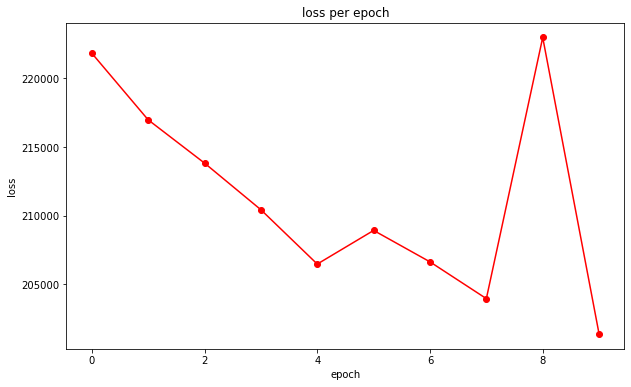

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
#print(loss_values)
plt.plot(loss_value,'-ro')
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

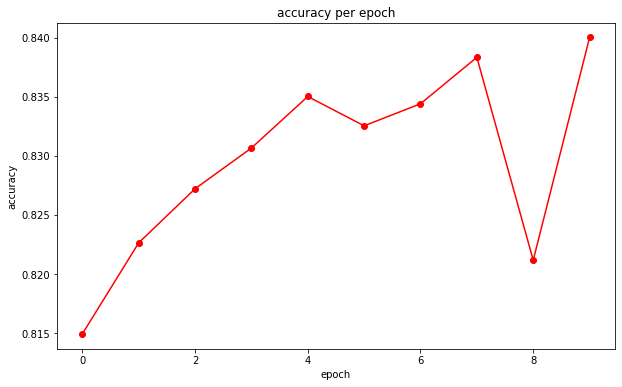

In [26]:
plt.plot(accuracies,'-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

# Evaluating the final result

84% accuracy is not bad considering the simplicity of the model, but >90% accuracy has been achieved in the past.

# How to improve our model?

<h4>Several options as follow:</h4>
<ul>
    <li>Regularization of Neural Networks using DropConnect</li>
    <li>Multi-column Deep Neural Networks for Image Classification</li> 
    <li>APAC: Augmented Pattern Classification with Neural Networks</li>
    <li>Simple Deep Neural Network with Dropout</li>
</ul>
<h4>In the next part we are going to explore the option:</h4>
<ul>
    <li>Simple Deep Neural Network with Dropout (more than 1 hidden layer)</li>
</ul> 


# 2nd Part: Deep learning applied on MNIST

In the first part, we learned how to use a simple ANN to classify MNIST. Now we are going to expand our knowledge using a Deep Neural Network.

Architecture of our network is:

*   (Input) -> \[batch_size, 28, 28, 1]  >> Apply 32 filter of \[5x5]
*   (Convolutional layer 1)  -> \[batch_size, 28, 28, 32]
*   (ReLU 1)  -> \[?, 28, 28, 32]
*   (Max pooling 1) -> \[?, 14, 14, 32]
*   (Convolutional layer 2)  -> \[?, 14, 14, 64]
*   (ReLU 2)  -> \[?, 14, 14, 64]
*   (Max pooling 2)  -> \[?, 7, 7, 64]
*   \[fully connected layer 3] -> \[1x1024]
*   \[ReLU 3]  -> \[1x1024]
*   \[Drop out]  -> \[1x1024]
*   \[fully connected layer 4] -> \[1x10]

The next cells will explore this new architecture.


## Initial parameters

In [27]:
width = 28
height = 28  # height and width of image pixel
flat = width * height
class_output = 10  # number from 0 to 9

## Converting images ofthe data set to tensors

The input image is 28 pixels by 28 pixels, 1 channel (grayscale). In this case, the first dimension is the batch number of the image, and can be of any size (so we set it to -1). The second and third dimensions are width and height, and the last one is the image channels.

In [28]:
x_image_train = tf.reshape(x_train, [-1, 28, 28, 1])
x_image_train = tf.cast(x_image_train, 'float32')

x_image_test = tf.reshape(x_test, [-1, 28, 28, 1])
x_image_test = tf.cast(x_image_test, 'float32')

# Create new dataset with reshape inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

## Convolutional Layer 1

<h4>Defining kernel weight and bias</h4>
We define a kernel here. The Size of the filter/kernel is 5x5;  Input channels is 1 (grayscale);  and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of convolution layer would be 28x28x32). In this step, we create a filter / kernel tensor of shape <code>[filter_height, filter_width, in_channels, out_channels]</code>

In [29]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # 32 bias for 32 outputs

<img src="https://ibm.box.com/shared/static/vn26neef1nnv2oxn5cb3uueowcawhkgb.png" style="width: 800px; height: 400px;" alt="HTML5 Icon" >

</h4>Convolve with weight tensor and add biases.</h4>

To create convolutional layer, we use <b>tf.nn.conv2d</b>. It computes a 2-D convolution given 4-D input and filter tensors.

Inputs:

*   tensor of shape \[batch, in_height, in_width, in_channels]. x of shape \[batch_size,28 ,28, 1]

*   a filter / kernel tensor of shape \[filter_height, filter_width, in_channels, out_channels]. W is of size \[5, 5, 1, 32]

*   stride which is  \[1, 1, 1, 1]. The convolutional layer, slides the "kernel window" across the input tensor. As the input tensor has 4 dimensions:  \[batch, height, width, channels], then the convolution operates on a 2D window on the height and width dimensions. **strides** determines how much the window shifts by in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. \[1, 2, 2, 1]

Process:

*   Change the filter to a 2-D matrix with shape \[5\*5\*1,32]
*   Extracts image patches from the input tensor to form a *virtual* tensor of shape `[batch, 28, 28, 5*5*1]`.
*   For each batch, right-multiplies the filter matrix and the image vector.

Output:

*   A `Tensor` (a 2-D convolution) of size tf.Tensor 'add\_7:0' shape=(?, 28, 28, 32)- Notice: the output of the first convolution layer is 32 \[28x28] images. Here 32 is considered as volume/depth of the output image.

In [30]:
def convolve1(x):
    return (tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

<img src="https://ibm.box.com/shared/static/iizf4ui4b2hh9wn86pplqxu27ykpqci9.png" style="width: 800px; height: 400px;" alt="HTML5 Icon" >


# Apply the ReLU activation function

In this step, we just go through all outputs convolution layer, <b>convolve1</b>, and wherever a negative number occurs, we swap it out for a 0. It is called ReLU activation Function.<br> Let f(x) is a ReLU activation function $f(x) = max(0,x)$.

In [31]:
def h_conv1(x): return (tf.nn.relu(convolve1(x)))

## Apply the max pooling

<b>max pooling</b> is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and, and then find the maximum value for that region.

Lets use <b>tf.nn.max_pool</b> function to perform max pooling. <b>Kernel size:</b> 2x2 (if the window is a 2x2 matrix, it would result in one output pixel)\ <b>Strides:</b> dictates the sliding behaviour of the kernel. In this case it will move 2 pixels everytime, thus not overlapping. The input is a matrix of size 28x28x32, and the output would be a matrix of size 14x14x32.

<img src="https://ibm.box.com/shared/static/kmaja90mn3aud9mro9cn8pbbg1h5pejy.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 


In [32]:
def conv1(x):
    return tf.nn.max_pool(h_conv1(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

## Convolution layer 2

<h4>Weights and Biases of kernels</h4>

We apply the convolution again in this layer. Lets look at the second layer kernel:

*   Filter/kernel: 5x5 (25 pixels)
*   Input channels: 32 (from the 1st Conv layer, we had 32 feature maps)
*   64 output feature maps

<b>Notice:</b> here, the input image is \[14x14x32], the filter is \[5x5x32], we use 64 filters of size \[5x5x32], and the output of the convolutional layer would be 64 convolved image, \[14x14x64].

<b>Notice:</b> the convolution result of applying a filter of size \[5x5x32] on image of size \[14x14x32] is an image of size \[14x14x1], that is, the convolution is functioning on volume.


In [33]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))  # 64 bias for 64 inputs

## Convolve image with weight and tensor and add bias

In [34]:
def convolve2(x):
    return (tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

## Apply the ReLU activation function

In [35]:
def h_conv2(x): return tf.nn.relu(convolve2(x))

## Apply the max pooling

In [36]:
def conv2(x):
    return (tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

Second layer completed. So, what is the output of the second layer, layer2?

*   it is 64 matrix of \[7x7]

## Fully connected Layer

You need a fully connected layer to use the Softmax and create the probabilities in the end. Fully connected layers take the high-level filtered images from previous layer, that is all 64 matrices, and convert them to a flat array.

So, each matrix \[7x7] will be converted to a matrix of \[49x1], and then all of the 64 matrix will be connected, which make an array of size \[3136x1]. We will connect it into another layer of size \[1024x1]. So, the weight between these 2 layers will be \[3136x1024]

<img src="https://ibm.box.com/shared/static/pr9mnirmlrzm2bitf1d4jj389hyvv7ey.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 

## Flattening 2nd layer

In [37]:
def layer2_matrix(x): return tf.reshape(conv2(x), [-1, 7*7*64])

## Weights and Biases between layer 2 and 3

In [38]:
W_fc1 = tf.Variable(tf.random.truncated_normal([7*7*64, 1024], stddev=0.1, seed=2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))  # 1024 biases for 1024 output

## Matrix multiplication (apply weight and bias)

In [39]:
def fc1(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

## Apply the ReLU activation Function

In [40]:
def h_fc1(x): return tf.nn.relu(fc1(x))

## Dropout layer, optional phase for reducing overfitting

It is a phase where the network "forget" some features. At each training step in a mini-batch, some units get switched off randomly so that it will not interact with the network. That is, it weights cannot be updated, nor affect the learning of the other network nodes.  This can be very useful for very large neural networks to prevent overfitting.

In [41]:
keep_prob = 0.5
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

## Readout layer (Softmax layer)

## Weight and bias

In last layer, CNN takes the high-level filtered images and translate them into votes using softmax.
Input channels: 1024 (neurons from the 3rd Layer); 10 output features

In [42]:
W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed=2))  # 1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))  # 10 possibilities for number 0->9

## Applying weight and bias

In [43]:
def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2

## Apply the softmax function

In [44]:
def y_CNN(x): return tf.nn.softmax(fc(x))

<a id="ref7"></a>

<h2>Summary of the Deep Convolutional Neural Network</h2>

#### 0) Input - MNIST dataset

#### 1) Convolutional and Max-Pooling

#### 2) Convolutional and Max-Pooling

#### 3) Fully Connected Layer

#### 4) Processing - Dropout

#### 5) Readout layer - Fully Connected

#### 6) Outputs - Classified digits

# Define function and train the model

## Define the loss function

We need to compare our output, layer4 tensor, with ground truth for all mini_batch. we can use <b>cross entropy>/b> to see how bad our CNN is working - to measure the error at a softmax layer.

The following code shows an toy sample of cross-entropy for a mini-batch of size 2 which its items have been classified. You can run it (first change the cell type to <b>code</b> in the toolbar) to see how cross entropy changes.

In [45]:
import numpy as np
layer4_test =[[0.9, 0.1, 0.1],[0.9, 0.1, 0.1]]
y_test=[[1.0, 0.0, 0.0],[1.0, 0.0, 0.0]]
np.mean( -np.sum(y_test * np.log(layer4_test),1))

0.10536051565782628

<b>reduce_sum</b> computes the sum of elements of <b>(y\_ \* tf.log(layer4)</b> across second dimension of the tensor, and <b>reduce_mean</b> computes the mean of all elements in the tensor..

$$ CrossEntropy = \sum{y\_{Label}\cdot \log(y\_{Prediction})}$$


In [46]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

## Define the optimizer

It is obvious that we want minimize the error of our network which is calculated by cross_entropy metric. To solve the problem, we have to compute gradients for the loss (which is minimizing the cross-entropy) and apply gradients to variables. It will be done by an optimizer: GradientDescent or Adagrad.

In [47]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [48]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2,]

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy(y, y_CNN(x))
        grads = tape.gradient(current_loss, variables)
        optimizer.apply_gradients(zip(grads, variables))

        return current_loss.numpy()

## Define prediction

In [50]:
correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))

## Define accuracy

In [51]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

# Run session and train

In [52]:
loss_values = []
accuracies = []
epochs = 10

for i in range(epochs):
    j=0

    for x_train_batch, y_train_batch in train_ds2:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j % 50 == 0:
            correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
            #  accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss),
                  "accuracy", str(accuracy)) 
    
    current_loss = cross_entropy( y_train, y_CNN( x_image_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy))  

epoch  0 batch 50 loss: 107.115395 accuracy 0.46
epoch  0 batch 100 loss: 52.42914 accuracy 0.6
epoch  0 batch 150 loss: 35.0821 accuracy 0.72
epoch  0 batch 200 loss: 17.083889 accuracy 0.86
epoch  0 batch 250 loss: 35.564476 accuracy 0.82
epoch  0 batch 300 loss: 21.157684 accuracy 0.9
epoch  0 batch 350 loss: 25.186386 accuracy 0.8
epoch  0 batch 400 loss: 13.198561 accuracy 0.9
epoch  0 batch 450 loss: 21.947456 accuracy 0.86
epoch  0 batch 500 loss: 15.291687 accuracy 0.9
epoch  0 batch 550 loss: 16.40176 accuracy 0.9
epoch  0 batch 600 loss: 21.532248 accuracy 0.9
epoch  0 batch 650 loss: 15.331669 accuracy 0.86
epoch  0 batch 700 loss: 8.032148 accuracy 0.98
epoch  0 batch 750 loss: 29.274931 accuracy 0.9
epoch  0 batch 800 loss: 10.127683 accuracy 0.94
epoch  0 batch 850 loss: 11.811855 accuracy 0.92
epoch  0 batch 900 loss: 10.010102 accuracy 0.92
epoch  0 batch 950 loss: 16.574203 accuracy 0.88
epoch  0 batch 1000 loss: 13.436437 accuracy 0.92
epoch  0 batch 1050 loss: 4.0884

# Evaluate the model

In [53]:
j=0
acccuracies=[]
# evaluate accuracy by batch and average...reporting every 100th batch
for x_train_batch, y_train_batch in train_ds2:
        j+=1
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        #accuracies.append(accuracy)
        if j%100==0:
            print("batch", str(j), "accuracy", str(accuracy) ) 
import numpy as np
print("accuracy of entire set", str(np.mean(accuracies)))        

batch 100 accuracy 1.0
batch 200 accuracy 1.0
batch 300 accuracy 1.0
batch 400 accuracy 1.0
batch 500 accuracy 1.0
batch 600 accuracy 0.98
batch 700 accuracy 1.0
batch 800 accuracy 1.0
batch 900 accuracy 1.0
batch 1000 accuracy 1.0
batch 1100 accuracy 1.0
batch 1200 accuracy 1.0
accuracy of entire set 0.97956336


# Visualization

In [54]:
import utils
import imp
imp.reload(utils)
from utils import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels.numpy(), img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

NameError: name 'kernels' is not defined

Do you want to see the output of an image passing through first convolution layer?


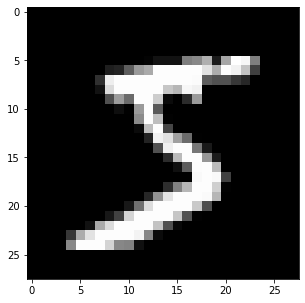

In [55]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = [x_image_train[0]]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")

In [56]:
keep_prob=1.0
ActivatedUnits = convolve1(sampleimage)
                           
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

UnboundLocalError: local variable 'ndims' referenced before assignment

What about second convolution layer?


In [57]:
ActivatedUnits = convolve2(sampleimage)
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

UnboundLocalError: local variable 'ndims' referenced before assignment